# Lab 6: Support Vector Machines and the Percolator algorithm

In this lab we'll be taking an in-depth dive into Percolator algorithm for proteomics that and a Python implementation of that algorithm, mokapot (*disclaimer: Will wrote mokapot*). We'll start by discussing how Percolator algorithm works, use it with mokapot, try to break in a way that violates the prime directive, and finaly compare the SVM to logistic regression.

Before we begin, run the code cell below to import the functionality we'll need for this lab. The code also sets our plotting them and defines the path to an example file from a single-cell proteomics experiment ([Specht et al](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02267-5)).

In [1]:
import logging                   # Control logging messages.
import mokapot                   # Our Python implementatation of the Percolator algorithm.
import matplotlib.pyplot as plt  # For creating plots.
import seaborn as sns            # To make the plots a little prettier.
import numpy as np               # Just to set the random seed.

# So we can train a logistic regression model too.
# LogisticRegressionCV let's us find the optimal hyperparameters by cross-validation.
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC      # SVC let's us use kernels.
from sklearn.model_selection import GridSearchCV  # For choosing hyperparameters by cross-validation.

# Show logging messages from mokapot:
logging.basicConfig(level=logging.INFO, format="%(message)s")

# Set our plot style:
sns.set(context="notebook", style="ticks")

# An example input file for us to work with:
example_file = "../data/pin_files/scope2_FP97AC.pin"

## Background: What is the Percolator algorithm and how does it work?

Percolator is a proteomics tool that is used to re-score peptide-spectrum matches (PSMs) from a proteomics experiment using a machine learning algorithm ([Käll et al](https://www.nature.com/articles/nmeth1113)). It has been extremely popular and is integrated with other tools like Proteome Discoverer, Mascot, and EncyclopeDIA. As a tool, Percolator both boosts the number of peptides we can detect in proteomics experiments with its machine learning algorithm and provides a consistent statical framework to interpret the resulting identifications. Although Percolator was specifically developed for proteomics data, it provides and excellent example of using an SVM and cross-validation to great effect. The tool we'll be using today is [mokapot](https://mokapot.readthedocs.io/en/latest/), a Python implementation of the Percolator algorithm that allows us to explore the algorithm in more detail ([Fondrie and Noble](https://pubs.acs.org/doi/10.1021/acs.jproteome.0c01010)).

Here's how it works:

### Target-decoy competition can be used to assess error rates.

In proteomics experiments, we are often interested in quantifying how confident we are about how assignment of peptides to tandem mass spectra by a database search engine. By far the most popular method to assign confidence estimates to our PSMs is using target-decoy competition (also known as the target-decoy approach). The priciples behind target-decoy competition are suprising simple, but powerful for interpreting proteomics data.

To perform target-decoy competition, we start by generating decoy peptides from a protein database by shuffling the real peptides sequences (the *targets*), but maintaining the terminal residues to preserve enzymatic cleavage sites. These new decoy sequences should not be present in the sample that was analyzed, and thus let us see how well incorrect PSMs are scored. If we only allow one peptide to be assigned to each spectrum, the the target and decoy sequence must compete against one another for each asignment. *A small aside: Reversing peptide sequences is just one instance of shuffling the sequence.* 

We expect to see a score distribution from our search engine that looks like this one:
![](images/tdc.jpg)

We can then draw a vertical line that is our score threshold, above which we accept our PSMs and below which we reject them. Using the target and decoy PSMs that we accept, we can then estimate the false discovery rate (FDR) for this set PSMs as: 

$$ FDR = \frac{\#~decoys + 1}{\#~targets} $$ 

One other term you'll need to understand Percolator algorithm is the q-value. Imagine that you picked every possible score threshold in your dataset and computed the FDR using the equation above. The q-value tells us where to threshold data get the maximum number of PSMs acheiving an FDR less than or equal to the q-value threshold. Practically speaking, the q-value and FDR can typically be used interchangeably. For more discussion about q-values and other confidence estimates, see [Käll et al]().

### Percolator uses an SVM to separate high-scoring target sequences from decoy sequences.

Thus far we've discussed supervised and unsuperised learning in this course, and we've only seen SVMs used for the supervised learning tasks. However, the Percolator algorithm's task is actually an instance of something new: semi-supervised learning. 

Semi-supervised learning describes tasks where the labels you want your model to predict are noisy; that is, some are incorrect or missing. In our case, we ideally want to separate our correct PSMs from our incorrect PSMs. However, we don't know which are the correct PSMs to begin with! Instead, we know that target PSMs are either correct or incorrect and we assume that our decoy PSMs are all incorrect, leaving us with noisly labels for "correct" PSMs. How does Percolator algorithm deal with these noisy labels? By leveraging the FDR calculation we discussed above.

Instead of defining every target as a positive example and every decoy as a negative example as we would in a supervised learning problem, the Percolator algorithm uses only the most confident PSMs as postive examples. You might be wondering then, "how does Percolator algorithm find its initial set of positive examples?" That is an excellent question, and the answer is: The algorithm looks at all of the provided features and uses the one that yields the most target sequence below an FDR threshold (1% is the default). With the initial set of confident targets as positive examples and the decoys as negative examples, Percolator algorithm then fits an SVM model to the features. Then, using the predictions from fitted model, it calculates q-values and selects PSMs with an FDR below the same specified threshold as the new positive examples. Then the algorithm fits a new SVM model with the new labels, uses the model to get new positive labels, and repeats the process again. And it does this all within the context of cross-validation to prevent over-optimistic confidence estimates from overfitting. Here's an overview of how Percolator algorithm works:

![](images/percolator.jpg)


### Wait! What features does mokapot/Percolator use to do all of this?
The tab-delimited file used as input for mokapot and Percolator can contain whatever features you want. Most proteomics search engines create features for multiple scores of PSM quality, properties of the spectrum (such as the retention time) and properties of the peptide precursor (such as charge state and length). Let's take a look at an example file generated by the [Tide search engine](https://crux.ms). The code below reads an example Percolator input file and returns a [Pandas](https://pandas.pydata.org/) DataFrame—a popular tool for working with tabular data in Python. 

**Run the code cell below to see the first five rows of the Percolator input file.** These are often called "PIN" files.

In [2]:
mokapot.read_pin(example_file, to_df=True).head()

Parsing PSMs...
Reading ../data/pin_files/scope2_FP97AC.pin...


,SpecId,Label,ScanNr,ExpMass,CalcMass,lnrSp,deltLCn,deltCn,Sp,IonFrac,...,Charge4,Charge5,enzN,enzC,enzInt,lnNumDSP,dM,absdM,Peptide,Proteins
0,target_0_5782_2_-1,True,5782,899.4276,899.4528,1.609438,0.339464,0.173338,1.481950,0.1,...,0,0,1,1,0,3.332205,-0.012597,0.012597,R.M[15.99]FGSGR.E,sp|Q9BSF8|BTBDA_HUMAN
1,target_0_5782_2_-1,True,5782,899.4276,899.4503,0.693147,0.166126,0.000000,42.449978,0.3,...,0,0,1,1,0,3.332205,-0.011346,0.011346,R.EGDHGR.E,sp|Q13332|PTPRS_HUMAN
2,target_0_5782_2_-1,True,5782,899.4276,956.4427,1.791759,0.166126,0.000000,1.481950,0.1,...,0,0,1,1,0,3.332205,0.028872,0.028872,K.CGDYGR.A,sp|Q9UII5|ZN107_HUMAN
3,target_0_5782_2_-1,True,5782,899.4276,956.4792,1.945910,0.166126,0.166126,1.481950,0.1,...,0,0,1,1,0,3.332205,0.010653,0.010653,R.CFSTGR.G,sp|O00750|P3C2B_HUMAN
4,target_0_5782_2_-1,True,5782,899.4276,956.4904,1.386294,0.000000,0.008136,9.283126,0.2,...,0,0,1,1,0,3.332205,0.005038,0.005038,R.ASCPHR.G,sp|A7E2Y1|MYH7B_HUMAN


## Let's run mokapot!

Now that we know how Percolator algorithm works, let's use it with mokapot. Use the code cell below to run mokapot on our example input file. Pay attention to the logging messages are printed and discuss how they correspond to the algorithm description above.

In [3]:
# Set the random seed
# This ensures the data is split the same way everytime this code is run.
np.random.seed(42)

# Read the PSMs and their features from the example file:
psms = mokapot.read_pin(example_file)

# Run the standard Percolator algorithm in mokapot:
results, models = mokapot.brew(psms)

Parsing PSMs...
Reading ../data/pin_files/scope2_FP97AC.pin...
Using 21 features:
  (1)	lnrSp
  (2)	deltLCn
  (3)	deltCn
  (4)	Sp
  (5)	IonFrac
  (6)	RefactoredXCorr
  (7)	NegLog10PValue
  (8)	NegLog10ResEvPValue
  (9)	NegLog10CombinePValue
  (10)	PepLen
  (11)	Charge1
  (12)	Charge2
  (13)	Charge3
  (14)	Charge4
  (15)	Charge5
  (16)	enzN
  (17)	enzC
  (18)	enzInt
  (19)	lnNumDSP
  (20)	dM
  (21)	absdM
Found 72600 PSMs.
  - 36300 target PSMs and 36300 decoy PSMs detected.
Splitting PSMs into 3 folds...

=== Analyzing Fold 1 ===
Finding initial direction...
	- Selected feature NegLog10CombinePValue with 1472 PSMs at q<=0.01.
Selecting hyperparameters...
	- class_weight = {0: 1, 1: 1}
Beginning training loop...
	- Iteration 0: 1553 training PSMs passed.
	- Iteration 1: 1531 training PSMs passed.
	- Iteration 2: 1606 training PSMs passed.
	- Iteration 3: 1605 training PSMs passed.
	- Iteration 4: 1616 training PSMs passed.
	- Iteration 5: 1633 training PSMs passed.
	- Iteration 6: 1645 t

Did it actually help? Let's take a look. The code cell below produces curves that are similar to the ROC curves we talked about yesterday. However, notice that instead of using sensitivity on the veritcal axis we use the number of acceped PSMs or peptides. Additionally, the horizontal axis is the q-value, which is the false discovery rate, instead of the false positive rate. In general, we care about PSMs and peptides at low FDR values (say 1%), so these plots are zoomed into q-values 0-0.1:

In [4]:
# First, calculate q-values with the best feature:
best_feature = psms.assign_confidence()

Selected NegLog10CombinePValue as the best feature.
Assigning confidence...
Performing target-decoy competition...
Keeping the best match per ScanNr+ExpMass columns...
	- Found 7273 PSMs from unique spectra.
	- Found 6913 unique peptides.
Assiging q-values to PSMs...
	- Found 2501 PSMs with q<=0.01
Assiging PEPs to PSMs...
Assiging q-values to peptides...
	- Found 2300 peptides with q<=0.01
Assiging PEPs to peptides...


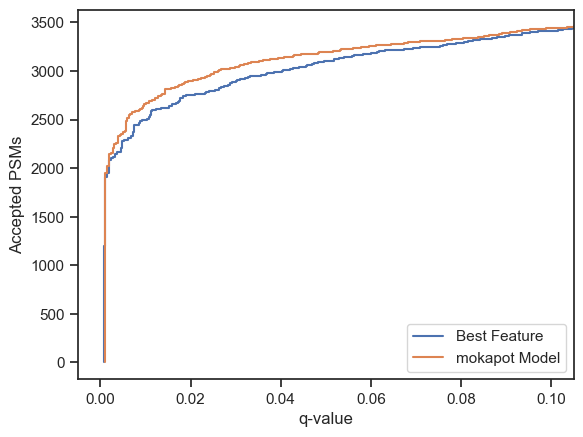

In [5]:
# Create a plot:
plt.figure()
best_feature.plot_qvalues(label="Best Feature")
results.plot_qvalues(label="mokapot Model")
plt.legend()
plt.show()

Does the model perform better than the best feature?

## What if we used logistic regression instead of an SVM?

The Percolator algorithm was originally written with an SVM model in mind. However, mokapot is able to use any model from scikit-learn, including logistic regression. Let's see how a logistic regression model performs when compared to the SVM normally used by mokapot and the Percolator algorithm:

In [6]:
# Create a Logistic Regression model:
lr_model = mokapot.Model(LogisticRegressionCV(solver="liblinear"))

# Use the model within mokapot, replacing the SVM:
lr_results, lr_models = mokapot.brew(psms, lr_model)

Splitting PSMs into 3 folds...

=== Analyzing Fold 1 ===
Finding initial direction...
	- Selected feature NegLog10CombinePValue with 1251 PSMs at q<=0.01.
Beginning training loop...
	- Iteration 0: 1287 training PSMs passed.
	- Iteration 1: 1526 training PSMs passed.
	- Iteration 2: 1513 training PSMs passed.
	- Iteration 3: 1568 training PSMs passed.
	- Iteration 4: 1585 training PSMs passed.
	- Iteration 5: 1614 training PSMs passed.
	- Iteration 6: 1629 training PSMs passed.
	- Iteration 7: 1636 training PSMs passed.
	- Iteration 8: 1629 training PSMs passed.
	- Iteration 9: 1635 training PSMs passed.
Normalized feature weights in the learned model:
    Feature                Weight
    lnrSp                  -0.19974723391590507
    deltLCn                2.437464207845207
    deltCn                 -1.1047830584621523
    Sp                     -0.1414013070380307
    IonFrac                0.2549374000145028
    RefactoredXCorr        -0.48974258906672785
    NegLog10PValue      

How can we determine which model (SVM or logistic regression) was better?

Let's look at the q-value curves again:

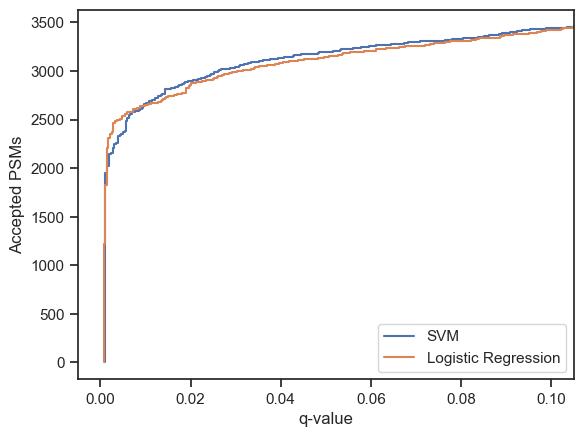

In [9]:
# Create a plot with the results from both models:
plt.figure()
results.plot_qvalues(label="SVM")
lr_results.plot_qvalues(label="Logistic Regression")
plt.legend()
plt.show()

## Questions to think about

1. What kinds of features would be problematic for the Percolator algorithm?
2. Why is cross-validation important in the Percolator algorithm?
3. We used a linear SVM - do you think a different kernel would work better? If you're curious follow the pattern we used for `LogisticRegressionCV`, but replace it with `SVC`. I recommend using the starting point below:

In [8]:
# Creates an SVM model with an radial basis function kernel
# The GridSearchCV will automatically pick the best hyper parameters
# in the param_grid that we provide using cross-validation.
# mokapot.model.PERC_GRID are just parameters to try.
rbf_svm_model = GridSearchCV(SVC(), param_grid=mokapot.model.PERC_GRID)

## More resources:
- The [mokapot documentation](https://mokapot.readthedocs.io)
- [Cross-validation in the Percolator algorithm](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-13-S16-S3)